In [ ]:
#Assignment 2 - Deep Learning
# 1.Image classification with modern MLP models
import numpy as np
import keras
from keras import layers

# Prepare the data
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

# Configure the hyperparameters
weight_decay = 0.0001
batch_size = 128
num_epochs = 25  # Set to 25 epochs
dropout_rate = 0.2
image_size = 64  # We'll resize input images to this size.
patch_size = 8  # Size of the patches to be extracted from the input images.
num_patches = (image_size // patch_size) ** 2  # Size of the data array.
embedding_dim = 256  # Number of hidden units.
num_blocks = 4  # Number of blocks.

print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")

# Use data augmentation
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

# Implement patch extraction as a layer
class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, x):
        patches = keras.ops.image.extract_patches(x, self.patch_size)
        batch_size = keras.ops.shape(patches)[0]
        num_patches = keras.ops.shape(patches)[1] * keras.ops.shape(patches)[2]
        patch_dim = keras.ops.shape(patches)[3]
        out = keras.ops.reshape(patches, (batch_size, num_patches, patch_dim))
        return out

# Implement position embedding as a layer
class PositionEmbedding(keras.layers.Layer):
    def __init__(
        self,
        sequence_length,
        initializer="glorot_uniform",
        **kwargs,
    ):
        super().__init__(**kwargs)
        if sequence_length is None:
            raise ValueError("`sequence_length` must be an Integer, received `None`.")
        self.sequence_length = int(sequence_length)
        self.initializer = keras.initializers.get(initializer)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "initializer": keras.initializers.serialize(self.initializer),
            }
        )
        return config

    def build(self, input_shape):
        feature_size = input_shape[-1]
        self.position_embeddings = self.add_weight(
            name="embeddings",
            shape=[self.sequence_length, feature_size],
            initializer=self.initializer,
            trainable=True,
        )

        super().build(input_shape)

    def call(self, inputs, start_index=0):
        shape = keras.ops.shape(inputs)
        feature_length = shape[-1]
        sequence_length = shape[-2]
        # trim to match the length of the input sequence, which might be less
        # than the sequence_length of the layer.
        position_embeddings = keras.ops.convert_to_tensor(self.position_embeddings)
        position_embeddings = keras.ops.slice(
            position_embeddings,
            (start_index, 0),
            (sequence_length, feature_length),
        )
        return keras.ops.broadcast_to(position_embeddings, shape)

    def compute_output_shape(self, input_shape):
        return input_shape

# Build a classification model
def build_classifier(blocks, positional_encoding=False):
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches to generate a [batch_size, num_patches, embedding_dim] tensor.
    x = layers.Dense(units=embedding_dim)(patches)
    if positional_encoding:
        x = x + PositionEmbedding(sequence_length=num_patches)(x)
    # Process x using the module blocks.
    x = blocks(x)
    # Apply global average pooling to generate a [batch_size, embedding_dim] representation tensor.
    representation = layers.GlobalAveragePooling1D()(x)
    # Apply dropout.
    representation = layers.Dropout(rate=dropout_rate)(representation)
    # Compute logits outputs.
    logits = layers.Dense(num_classes)(representation)
    # Create the Keras model.
    return keras.Model(inputs=inputs, outputs=logits)

# Define an experiment
def run_experiment(model):
    # Create Adam optimizer with weight decay.
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate,
        weight_decay=weight_decay,
    )
    # Compile the model.
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc"),
        ],
    )
    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    # Fit the model with verbose output to monitor progress
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[early_stopping, reduce_lr],
        verbose=1,  # Show progress during training
    )

    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    # Return history to plot learning curves.
    return history

# The MLP-Mixer model
class MLPMixerLayer(layers.Layer):
    def __init__(self, num_patches, hidden_units, dropout_rate, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.mlp1 = keras.Sequential(
            [
                layers.Dense(units=num_patches, activation="gelu"),
                layers.Dense(units=num_patches),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.mlp2 = keras.Sequential(
            [
                layers.Dense(units=num_patches, activation="gelu"),
                layers.Dense(units=hidden_units),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.normalize = layers.LayerNormalization(epsilon=1e-6)

    def build(self, input_shape):
        return super().build(input_shape)

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize(inputs)
        # Transpose inputs from [num_batches, num_patches, hidden_units] to [num_batches, hidden_units, num_patches].
        x_channels = keras.ops.transpose(x, axes=(0, 2, 1))
        # Apply mlp1 on each channel independently.
        mlp1_outputs = self.mlp1(x_channels)
        # Transpose mlp1_outputs from [num_batches, hidden_dim, num_patches] to [num_batches, num_patches, hidden_units].
        mlp1_outputs = keras.ops.transpose(mlp1_outputs, axes=(0, 2, 1))
        # Add skip connection.
        x = mlp1_outputs + inputs
        # Apply layer normalization.
        x_patches = self.normalize(x)
        # Apply mlp2 on each patch independently.
        mlp2_outputs = self.mlp2(x_patches)
        # Add skip connection.
        x = x + mlp2_outputs
        return x

# Build, train, and evaluate the MLP-Mixer model
mlpmixer_blocks = keras.Sequential(
    [MLPMixerLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
learning_rate = 0.005
mlpmixer_classifier = build_classifier(mlpmixer_blocks)
history = run_experiment(mlpmixer_classifier)
# Save with .keras format
mlpmixer_classifier.save('mlpmixer_model.keras')

# The FNet model
class FNetLayer(layers.Layer):
    def __init__(self, embedding_dim, dropout_rate, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.ffn = keras.Sequential(
            [
                layers.Dense(units=embedding_dim, activation="gelu"),
                layers.Dropout(rate=dropout_rate),
                layers.Dense(units=embedding_dim),
            ]
        )

        self.normalize1 = layers.LayerNormalization(epsilon=1e-6)
        self.normalize2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Apply fourier transformations.
        real_part = inputs
        im_part = keras.ops.zeros_like(inputs)
        x = keras.ops.fft2((real_part, im_part))[0]
        # Add skip connection.
        x = x + inputs
        # Apply layer normalization.
        x = self.normalize1(x)
        # Apply Feedforward network.
        x_ffn = self.ffn(x)
        # Add skip connection.
        x = x + x_ffn
        # Apply layer normalization.
        return self.normalize2(x)

# Build, train, and evaluate the FNet model
fnet_blocks = keras.Sequential(
    [FNetLayer(embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
learning_rate = 0.001
fnet_classifier = build_classifier(fnet_blocks, positional_encoding=True)
history = run_experiment(fnet_classifier)
# Save with .keras format
fnet_classifier.save('fnet_model.keras')

# The gMLP model
class gMLPLayer(layers.Layer):
    def __init__(self, num_patches, embedding_dim, dropout_rate, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.channel_projection1 = keras.Sequential(
            [
                layers.Dense(units=embedding_dim * 2, activation="gelu"),
                layers.Dropout(rate=dropout_rate),
            ]
        )

        self.channel_projection2 = layers.Dense(units=embedding_dim)

        self.spatial_projection = layers.Dense(
            units=num_patches, bias_initializer="Ones"
        )

        self.normalize1 = layers.LayerNormalization(epsilon=1e-6)
        self.normalize2 = layers.LayerNormalization(epsilon=1e-6)

    def spatial_gating_unit(self, x):
        # Split x along the channel dimensions.
        # Tensors u and v will in the shape of [batch_size, num_patchs, embedding_dim].
        u, v = keras.ops.split(x, indices_or_sections=2, axis=2)
        # Apply layer normalization.
        v = self.normalize2(v)
        # Apply spatial projection.
        v_channels = keras.ops.transpose(v, axes=(0, 2, 1))
        v_projected = self.spatial_projection(v_channels)
        v_projected = keras.ops.transpose(v_projected, axes=(0, 2, 1))
        # Apply element-wise multiplication.
        return u * v_projected

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize1(inputs)
        # Apply the first channel projection. x_projected shape: [batch_size, num_patches, embedding_dim * 2].
        x_projected = self.channel_projection1(x)
        # Apply the spatial gating unit. x_spatial shape: [batch_size, num_patches, embedding_dim].
        x_spatial = self.spatial_gating_unit(x_projected)
        # Apply the second channel projection. x_projected shape: [batch_size, num_patches, embedding_dim].
        x_projected = self.channel_projection2(x_spatial)
        # Add skip connection.
        return x + x_projected

# Build, train, and evaluate the gMLP model
gmlp_blocks = keras.Sequential(
    [gMLPLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
learning_rate = 0.003
gmlp_classifier = build_classifier(gmlp_blocks)
history = run_experiment(gmlp_classifier)
# Save with .keras format
gmlp_classifier.save('gmlp_model.keras')

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)
Image size: 64 X 64 = 4096
Patch size: 8 X 8 = 64 
Patches per image: 64
Elements per patch (3 channels): 192
Epoch 1/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 33s 52ms/step - acc: 0.0744 - loss: 4.1608 - top5-acc: 0.2370 - val_acc: 0.1878 - val_loss: 3.4588 - val_top5-acc: 0.4462 - learning_rate: 0.0050
Epoch 2/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - acc: 0.1848 - loss: 3.4210 - top5-acc: 0.4510 - val_acc: 0.2104 - val_loss: 3.2749 - val_top5-acc: 0.5090 - learning_rate: 0.0050
Epoch 3/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - acc: 0.2183 - loss: 3.2155 - top5-acc: 0.5004 - val_acc: 0.2576 - val_loss: 3.0412 - val_top5-acc: 0.5576 - learning_rate: 0.0050
Epoch 4/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - acc: 0.2489 - loss: 3.0455 - top5-acc: 0.5458 - val_acc: 0.2532 - val_loss: 3.0424 - val_top5-acc: 0.

In [ ]:
# 2) mplement RNN for sentiment analysis on movie reviews.
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Load IMDB dataset
max_features = 10000  # Top 10,000 words
max_len = 500  # Max sequence length
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

# Build LSTM model (updated to remove input_length)
model = Sequential()
model.add(Embedding(max_features, 128))  # Removed input_length
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Evaluate
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')
model.save('sentiment_rnn.keras')

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 631s 1s/step - accuracy: 0.6961 - loss: 0.5582 - val_accuracy: 0.8344 - val_loss: 0.3810
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 626s 1s/step - accuracy: 0.8355 - loss: 0.3805 - val_accuracy: 0.8200 - val_loss: 0.4229
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 628s 1s/step - accuracy: 0.8708 - loss: 0.3102 - val_accuracy: 0.8470 - val_loss: 0.3652
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 628s 1s/step - accuracy: 0.9118 - loss: 0.2347 - val_accuracy: 0.8602 - val_loss: 0.3532
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 628s 1s/step - accuracy: 0.9352 - loss: 0.1774 - val_accuracy: 0.7990 - val_loss: 0.4767
782/782 ━━━━━━━━━━━━━━━━━━━━ 223s 285ms/step - accuracy: 0.7868 - loss: 0.5082
Accuracy: 78.61%


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 203kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.76MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 25.2MB/s]


Autoencoder(
  (enc1): Linear(in_features=784, out_features=256, bias=True)
  (enc2): Linear(in_features=256, out_features=128, bias=True)
  (enc3): Linear(in_features=128, out_features=64, bias=True)
  (enc4): Linear(in_features=64, out_features=32, bias=True)
  (enc5): Linear(in_features=32, out_features=16, bias=True)
  (dec1): Linear(in_features=16, out_features=32, bias=True)
  (dec2): Linear(in_features=32, out_features=64, bias=True)
  (dec3): Linear(in_features=64, out_features=128, bias=True)
  (dec4): Linear(in_features=128, out_features=256, bias=True)
  (dec5): Linear(in_features=256, out_features=784, bias=True)
)
cuda:0
Epoch 1 of 50, Train Loss: 0.072
Epoch 2 of 50, Train Loss: 0.038
Epoch 3 of 50, Train Loss: 0.033
Epoch 4 of 50, Train Loss: 0.030
Epoch 5 of 50, Train Loss: 0.029
Epoch 6 of 50, Train Loss: 0.028
Epoch 7 of 50, Train Loss: 0.027
Epoch 8 of 50, Train Loss: 0.026
Epoch 9 of 50, Train Loss: 0.026
Epoch 10 of 50, Train Loss: 0.025
Epoch 11 of 50, Train Loss:

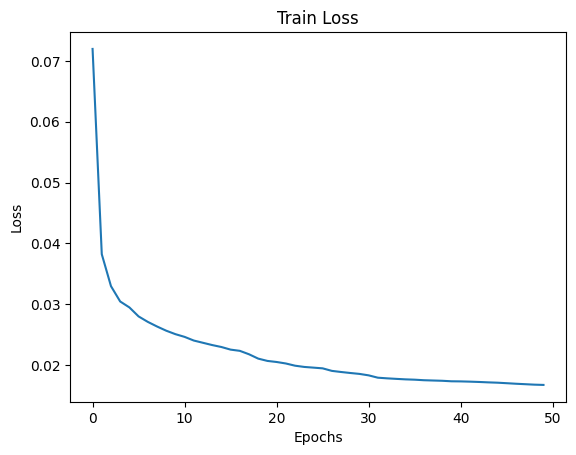

In [1]:
# 3.Demonstrate the different types of autoencoders using Fashion MNIST dataset and any industrial dataset.
import os
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image

# constants
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 128

# image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
testset = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

trainloader = DataLoader(
    trainset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
testloader = DataLoader(
    testset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# utility functions
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

def make_dir():
    image_dir = 'FashionMNIST_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)

def save_decoded_image(img, epoch):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, './FashionMNIST_Images/linear_ae_image{}.png'.format(epoch))

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=16)

        # decoder
        self.dec1 = nn.Linear(in_features=16, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=784)

    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.enc5(x))

        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x))
        return x

net = Autoencoder()
print(net)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

def train(net, trainloader, NUM_EPOCHS):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data in trainloader:
            img, _ = data
            img = img.to(device)
            img = img.view(img.size(0), -1)
            optimizer.zero_grad()
            outputs = net(img)
            loss = criterion(outputs, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, NUM_EPOCHS, loss))

        if epoch % 5 == 0:
            save_decoded_image(outputs.cpu().data, epoch)

    return train_loss

def test_image_reconstruction(net, testloader):
     for batch in testloader:
        img, _ = batch
        img = img.to(device)
        img = img.view(img.size(0), -1)
        outputs = net(img)
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        save_image(outputs, 'fashionmnist_reconstruction.png')
        break

# get the computation device
device = get_device()
print(device)
# load the neural network onto the device
net.to(device)

make_dir()

# train the network
train_loss = train(net, trainloader, NUM_EPOCHS)
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('deep_ae_fashionmnist_loss.png')

# test the network
test_image_reconstruction(net, testloader)

In [4]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
import numpy as np # Import numpy

# Config (define your own or use these)
class config:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    BATCH_SIZE = 128
    CHANNELS = 1
    IMAGE_SIZE = 32  # Pad to 32 for even divisions
    EMBEDDING_DIM = 64
    LR = 0.001
    EPOCHS = 50
    PATIENCE = 5
    MODEL_WEIGHTS_PATH = 'conv_ae_weights.pt'
    training_progress_dir = 'training_progress'
    FILE_RECON_BEFORE_TRAINING = 'recon_before.png'
    FILE_REAL_BEFORE_TRAINING = 'real_before.png'
    CLASS_LABELS = {0: 'T-shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}  # Fashion MNIST labels

os.makedirs(config.training_progress_dir, exist_ok=True)

# Encoder
class Encoder(nn.Module):
    def __init__(self, image_size, channels, embedding_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(channels, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.shape_before_flattening = None
        flattened_size = (image_size // 8) * (image_size // 8) * 128
        self.fc = nn.Linear(flattened_size, embedding_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        self.shape_before_flattening = x.shape[1:]
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Decoder
class Decoder(nn.Module):
    def __init__(self, embedding_dim, shape_before_flattening, channels):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(embedding_dim, np.prod(shape_before_flattening))
        self.reshape_dim = shape_before_flattening
        self.deconv1 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv1 = nn.Conv2d(32, channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), *self.reshape_dim)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = torch.sigmoid(self.conv1(x))
        return x

# Utilities (simplified display_random_images and validate)
def display_random_images(data_loader, encoder, decoder, file_recon=None, display_real=False):
    # Simplified: save reconstructions
    for images, _ in data_loader:
        images = images.to(config.DEVICE)
        with torch.no_grad():
            encoded = encoder(images)
            recon = decoder(encoded)
        save_image(recon, file_recon)
        break

def validate(encoder, decoder, test_loader, criterion):
    encoder.eval()
    decoder.eval()
    val_loss = 0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(config.DEVICE)
            encoded = encoder(images)
            decoded = decoder(encoded)
            loss = criterion(decoded, images)
            val_loss += loss.item()
    return val_loss / len(test_loader)

# Training
transform = transforms.Compose([transforms.Pad(padding=2), transforms.ToTensor()])
trainset = datasets.FashionMNIST("data", train=True, download=True, transform=transform)
testset = datasets.FashionMNIST("data", train=False, download=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=config.BATCH_SIZE, shuffle=True)
test_loader = DataLoader(testset, batch_size=config.BATCH_SIZE, shuffle=True)

dummy_input = torch.randn(1, config.CHANNELS, config.IMAGE_SIZE, config.IMAGE_SIZE)
encoder = Encoder(channels=config.CHANNELS, image_size=config.IMAGE_SIZE, embedding_dim=config.EMBEDDING_DIM).to(config.DEVICE)
enc_out = encoder(dummy_input.to(config.DEVICE))
shape_before_flattening = encoder.shape_before_flattening
decoder = Decoder(config.EMBEDDING_DIM, shape_before_flattening, config.CHANNELS).to(config.DEVICE)

criterion = nn.BCELoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=config.LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=config.PATIENCE)

best_val_loss = float("inf")

for epoch in range(config.EPOCHS):
    print(f"Epoch: {epoch + 1}/{config.EPOCHS}")
    encoder.train()
    decoder.train()
    running_loss = 0.0
    for batch_idx, (data, _) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data = data.to(config.DEVICE)
        optimizer.zero_grad()
        encoded = encoder(data)
        decoded = decoder(encoded)
        loss = criterion(decoded, data)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    val_loss = validate(encoder, decoder, test_loader, criterion)
    print(f"Epoch {epoch + 1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({"encoder": encoder.state_dict(), "decoder": decoder.state_dict()}, config.MODEL_WEIGHTS_PATH)

    scheduler.step(val_loss)
    display_random_images(test_loader, encoder, decoder, file_recon=os.path.join(config.training_progress_dir, f"epoch{epoch + 1}_test_recon.png"))

print("Training finished!")

Epoch: 1/50


100%|██████████| 469/469 [00:14<00:00, 33.42it/s]


Epoch 1 | Train Loss: 0.2697 | Val Loss: 0.2227
Epoch: 2/50


100%|██████████| 469/469 [00:13<00:00, 34.02it/s]


Epoch 2 | Train Loss: 0.2151 | Val Loss: 0.2125
Epoch: 3/50


100%|██████████| 469/469 [00:13<00:00, 34.10it/s]


Epoch 3 | Train Loss: 0.2082 | Val Loss: 0.2079
Epoch: 4/50


100%|██████████| 469/469 [00:14<00:00, 33.42it/s]


Epoch 4 | Train Loss: 0.2048 | Val Loss: 0.2053
Epoch: 5/50


100%|██████████| 469/469 [00:14<00:00, 33.17it/s]


Epoch 5 | Train Loss: 0.2027 | Val Loss: 0.2028
Epoch: 6/50


100%|██████████| 469/469 [00:13<00:00, 34.50it/s]


Epoch 6 | Train Loss: 0.2013 | Val Loss: 0.2030
Epoch: 7/50


100%|██████████| 469/469 [00:13<00:00, 34.23it/s]


Epoch 7 | Train Loss: 0.2003 | Val Loss: 0.2012
Epoch: 8/50


100%|██████████| 469/469 [00:13<00:00, 34.58it/s]


Epoch 8 | Train Loss: 0.1994 | Val Loss: 0.2005
Epoch: 9/50


100%|██████████| 469/469 [00:13<00:00, 33.67it/s]


Epoch 9 | Train Loss: 0.1987 | Val Loss: 0.2005
Epoch: 10/50


100%|██████████| 469/469 [00:13<00:00, 34.73it/s]


Epoch 10 | Train Loss: 0.1982 | Val Loss: 0.1995
Epoch: 11/50


100%|██████████| 469/469 [00:13<00:00, 34.75it/s]


Epoch 11 | Train Loss: 0.1976 | Val Loss: 0.1992
Epoch: 12/50


100%|██████████| 469/469 [00:13<00:00, 34.20it/s]


Epoch 12 | Train Loss: 0.1972 | Val Loss: 0.1990
Epoch: 13/50


100%|██████████| 469/469 [00:13<00:00, 33.96it/s]


Epoch 13 | Train Loss: 0.1968 | Val Loss: 0.1984
Epoch: 14/50


100%|██████████| 469/469 [00:13<00:00, 35.05it/s]


Epoch 14 | Train Loss: 0.1965 | Val Loss: 0.1989
Epoch: 15/50


100%|██████████| 469/469 [00:13<00:00, 34.63it/s]


Epoch 15 | Train Loss: 0.1962 | Val Loss: 0.1975
Epoch: 16/50


100%|██████████| 469/469 [00:13<00:00, 34.43it/s]


Epoch 16 | Train Loss: 0.1960 | Val Loss: 0.1979
Epoch: 17/50


100%|██████████| 469/469 [00:13<00:00, 34.88it/s]


Epoch 17 | Train Loss: 0.1958 | Val Loss: 0.1973
Epoch: 18/50


100%|██████████| 469/469 [00:13<00:00, 34.90it/s]


Epoch 18 | Train Loss: 0.1956 | Val Loss: 0.1975
Epoch: 19/50


100%|██████████| 469/469 [00:13<00:00, 34.46it/s]


Epoch 19 | Train Loss: 0.1954 | Val Loss: 0.1968
Epoch: 20/50


100%|██████████| 469/469 [00:13<00:00, 34.05it/s]


Epoch 20 | Train Loss: 0.1953 | Val Loss: 0.1973
Epoch: 21/50


100%|██████████| 469/469 [00:13<00:00, 34.84it/s]


Epoch 21 | Train Loss: 0.1952 | Val Loss: 0.1969
Epoch: 22/50


100%|██████████| 469/469 [00:13<00:00, 34.81it/s]


Epoch 22 | Train Loss: 0.1950 | Val Loss: 0.1975
Epoch: 23/50


100%|██████████| 469/469 [00:13<00:00, 34.36it/s]


Epoch 23 | Train Loss: 0.1949 | Val Loss: 0.1965
Epoch: 24/50


100%|██████████| 469/469 [00:14<00:00, 33.36it/s]


Epoch 24 | Train Loss: 0.1948 | Val Loss: 0.1971
Epoch: 25/50


100%|██████████| 469/469 [00:14<00:00, 33.42it/s]


Epoch 25 | Train Loss: 0.1947 | Val Loss: 0.1967
Epoch: 26/50


100%|██████████| 469/469 [00:13<00:00, 34.61it/s]


Epoch 26 | Train Loss: 0.1946 | Val Loss: 0.1968
Epoch: 27/50


100%|██████████| 469/469 [00:14<00:00, 33.13it/s]


Epoch 27 | Train Loss: 0.1945 | Val Loss: 0.1968
Epoch: 28/50


100%|██████████| 469/469 [00:13<00:00, 34.61it/s]


Epoch 28 | Train Loss: 0.1944 | Val Loss: 0.1963
Epoch: 29/50


100%|██████████| 469/469 [00:13<00:00, 33.72it/s]


Epoch 29 | Train Loss: 0.1944 | Val Loss: 0.1966
Epoch: 30/50


100%|██████████| 469/469 [00:13<00:00, 34.11it/s]


Epoch 30 | Train Loss: 0.1943 | Val Loss: 0.1964
Epoch: 31/50


100%|██████████| 469/469 [00:13<00:00, 33.71it/s]


Epoch 31 | Train Loss: 0.1943 | Val Loss: 0.1961
Epoch: 32/50


100%|██████████| 469/469 [00:13<00:00, 34.60it/s]


Epoch 32 | Train Loss: 0.1942 | Val Loss: 0.1966
Epoch: 33/50


100%|██████████| 469/469 [00:13<00:00, 34.27it/s]


Epoch 33 | Train Loss: 0.1941 | Val Loss: 0.1962
Epoch: 34/50


100%|██████████| 469/469 [00:13<00:00, 33.55it/s]


Epoch 34 | Train Loss: 0.1941 | Val Loss: 0.1964
Epoch: 35/50


100%|██████████| 469/469 [00:13<00:00, 34.26it/s]


Epoch 35 | Train Loss: 0.1940 | Val Loss: 0.1961
Epoch: 36/50


100%|██████████| 469/469 [00:13<00:00, 34.38it/s]


Epoch 36 | Train Loss: 0.1940 | Val Loss: 0.1962
Epoch: 37/50


100%|██████████| 469/469 [00:13<00:00, 35.01it/s]


Epoch 37 | Train Loss: 0.1939 | Val Loss: 0.1959
Epoch: 38/50


100%|██████████| 469/469 [00:13<00:00, 33.90it/s]


Epoch 38 | Train Loss: 0.1939 | Val Loss: 0.1961
Epoch: 39/50


100%|██████████| 469/469 [00:13<00:00, 34.29it/s]


Epoch 39 | Train Loss: 0.1938 | Val Loss: 0.1963
Epoch: 40/50


100%|██████████| 469/469 [00:13<00:00, 34.34it/s]


Epoch 40 | Train Loss: 0.1938 | Val Loss: 0.1957
Epoch: 41/50


100%|██████████| 469/469 [00:13<00:00, 33.82it/s]


Epoch 41 | Train Loss: 0.1938 | Val Loss: 0.1959
Epoch: 42/50


100%|██████████| 469/469 [00:13<00:00, 34.30it/s]


Epoch 42 | Train Loss: 0.1937 | Val Loss: 0.1960
Epoch: 43/50


100%|██████████| 469/469 [00:13<00:00, 34.45it/s]


Epoch 43 | Train Loss: 0.1937 | Val Loss: 0.1960
Epoch: 44/50


100%|██████████| 469/469 [00:13<00:00, 34.62it/s]


Epoch 44 | Train Loss: 0.1937 | Val Loss: 0.1961
Epoch: 45/50


100%|██████████| 469/469 [00:14<00:00, 33.08it/s]


Epoch 45 | Train Loss: 0.1936 | Val Loss: 0.1960
Epoch: 46/50


100%|██████████| 469/469 [00:13<00:00, 34.71it/s]


Epoch 46 | Train Loss: 0.1936 | Val Loss: 0.1958
Epoch: 47/50


100%|██████████| 469/469 [00:13<00:00, 34.39it/s]


Epoch 47 | Train Loss: 0.1930 | Val Loss: 0.1953
Epoch: 48/50


100%|██████████| 469/469 [00:13<00:00, 34.28it/s]


Epoch 48 | Train Loss: 0.1930 | Val Loss: 0.1957
Epoch: 49/50


100%|██████████| 469/469 [00:13<00:00, 33.63it/s]


Epoch 49 | Train Loss: 0.1930 | Val Loss: 0.1959
Epoch: 50/50


100%|██████████| 469/469 [00:13<00:00, 33.85it/s]


Epoch 50 | Train Loss: 0.1930 | Val Loss: 0.1954
Training finished!
